In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from data_preparation import generate_data, T_total, T_pre, T_post
from bsts_model import metropolis_random_walk
from bsts_forecasting import posterior_predictive_forecast

In [2]:
y_obs, mu_true, sigma_trend_true = generate_data()

In [6]:
mu_post, sig_xi_post, sig_obs_post = metropolis_random_walk(
    y_obs[:T_pre], n_iters=12000, step_mu=0.25, step_sig=0.2, burn=4000, thin=5
)

In [7]:
h = T_post
mu_future_samps, y_future_samps = posterior_predictive_forecast(
    mu_post, sig_xi_post, sig_obs_post, h=h
)

In [8]:
# Counterfactual summaries
cf_mean = y_future_samps.mean(axis=0)
cf_low = np.percentile(y_future_samps, 5, axis=0)
cf_high = np.percentile(y_future_samps, 95, axis=0)

In [ ]:
# Causal effects (Observed - Counterfactual)
actual_post = y_obs[T_pre:]
point_effect = actual_post - cf_mean
cum_effect = np.cumsum(point_effect)

# Credible intervals from posterior draws
effect_draws = actual_post[None, :] - y_future_samps   # shape (n_draws, h)
point_low = np.percentile(effect_draws, 5, axis=0)
point_high = np.percentile(effect_draws, 95, axis=0)
cum_draws = np.cumsum(effect_draws, axis=1)
cum_low = np.percentile(cum_draws, 5, axis=0)
cum_high = np.percentile(cum_draws, 95, axis=0)

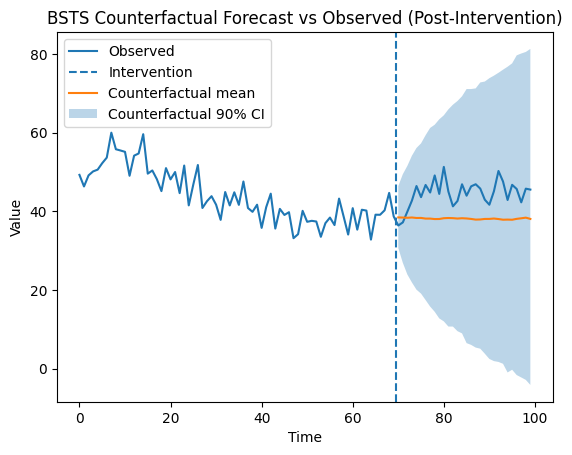

In [10]:
t = np.arange(T_total)

# (a) Observed series + counterfactual band (post only)
plt.figure()
plt.plot(t, y_obs, label="Observed")
plt.axvline(T_pre - 0.5, linestyle="--", label="Intervention")
plt.plot(np.arange(T_pre, T_total), cf_mean, label="Counterfactual mean")
plt.fill_between(np.arange(T_pre, T_total), cf_low, cf_high, alpha=0.3, label="Counterfactual 90% CI")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("BSTS Counterfactual Forecast vs Observed (Post-Intervention)")
plt.legend()
plt.show()

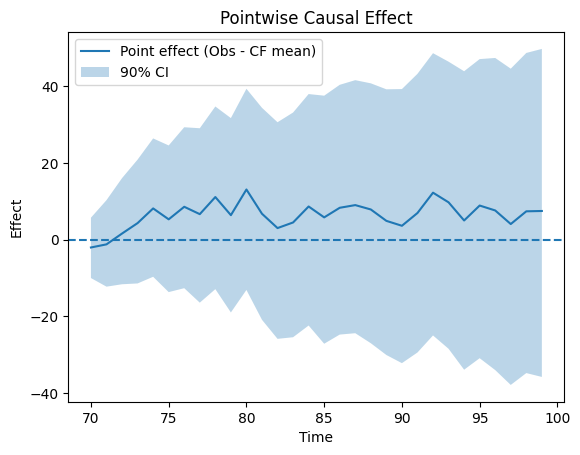

In [11]:
# (b) Pointwise effect
plt.figure()
plt.plot(np.arange(T_pre, T_total), point_effect, label="Point effect (Obs - CF mean)")
plt.fill_between(np.arange(T_pre, T_total), point_low, point_high, alpha=0.3, label="90% CI")
plt.axhline(0.0, linestyle="--")
plt.xlabel("Time")
plt.ylabel("Effect")
plt.title("Pointwise Causal Effect")
plt.legend()
plt.show()

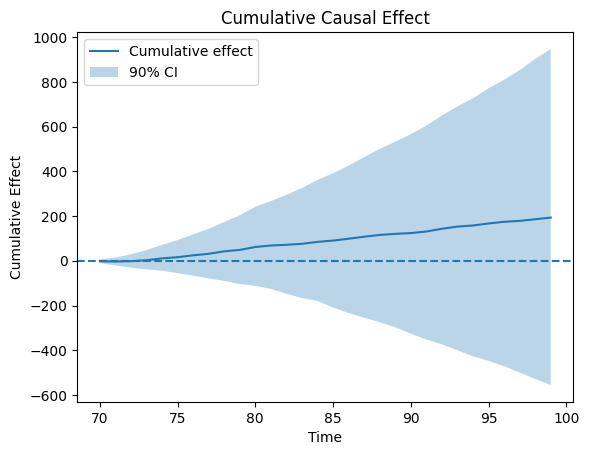

In [12]:
# (c) Cumulative effect
plt.figure()
plt.plot(np.arange(T_pre, T_total), cum_effect, label="Cumulative effect")
plt.fill_between(np.arange(T_pre, T_total), cum_low, cum_high, alpha=0.3, label="90% CI")
plt.axhline(0.0, linestyle="--")
plt.xlabel("Time")
plt.ylabel("Cumulative Effect")
plt.title("Cumulative Causal Effect")
plt.legend()
plt.show()